## 모델링

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# 1. 데이터 로드
dust_files = [
    "./data/1701Q_dust.csv", "./data/1702Q_dust.csv", "./data/1703Q_dust.csv",
    "./data/1704Q_dust.csv", "./data/1801Q_dust.csv", "./data/1802Q_dust.csv", "./data/1803Q_dust.csv"
]
dust_df = pd.concat([pd.read_csv(f) for f in dust_files], ignore_index=True)
dust_df['날짜'] = pd.to_datetime(dust_df['측정일시'].astype(str).str[:8], format='%Y%m%d')

weather_files = ["./data/SURFACE_air_pollution_2017.csv", "./data/SURFACE_air_pollution_2018.csv"]
weather_df = pd.concat([pd.read_csv(f, encoding='cp949') for f in weather_files], ignore_index=True)
weather_df['날짜'] = pd.to_datetime(weather_df['일시'], errors='coerce')

sales_df = pd.read_csv("./data/20190509_mask_POS.csv")
sales_df['날짜'] = pd.to_datetime(sales_df['Calendar Day일 2'])

# 2. 집계
dust_daily = dust_df.groupby(dust_df['날짜'].dt.date).mean(numeric_only=True).reset_index()
dust_daily['날짜'] = pd.to_datetime(dust_daily['날짜'])

weather_daily = weather_df.groupby(weather_df['날짜'].dt.date).mean(numeric_only=True).reset_index()
weather_daily['날짜'] = pd.to_datetime(weather_daily['날짜'])

sales_daily = sales_df.groupby(sales_df['날짜'].dt.date).sum(numeric_only=True).reset_index()
sales_daily['날짜'] = pd.to_datetime(sales_daily['날짜'])

# 3. 병합 및 파생 변수
merged = pd.merge(sales_daily, dust_daily, on='날짜', how='inner')
merged = pd.merge(merged, weather_daily, on='날짜', how='inner')
merged['체감온도'] = merged['기온(°C)'] - 0.7 * merged['풍속(m/s)'] + 0.03 * merged['습도(%)']
merged['기압차'] = merged['해면기압(hPa)'] - merged['현지기압(hPa)']
merged['월'] = merged['날짜'].dt.month
merged['요일'] = merged['날짜'].dt.dayofweek
merged['풍압'] = merged['풍속(m/s)'] * merged['풍향(16방위)']
merged['판매량_어제'] = merged['Sales Amt'].shift(1)
merged['판매량_7일평균'] = merged['Sales Amt'].rolling(window=7).mean()
merged = merged.dropna(subset=['판매량_어제', '판매량_7일평균']) # dropna를 전체 데이터프레임에 적용하지 않고, 해당 컬럼만 선택적으로 적용

# 이상치 제거 + 로그 변환
q1 = merged['Sales Amt'].quantile(0.25)
q3 = merged['Sales Amt'].quantile(0.75)
iqr = q3 - q1
merged = merged[(merged['Sales Amt'] >= q1 - 1.5 * iqr) & (merged['Sales Amt'] <= q3 + 1.5 * iqr)]
merged['Sales Amt'] = np.log1p(merged['Sales Amt'])

# 카테고리형 변수 원-핫 인코딩
merged = pd.get_dummies(merged, columns=['요일', '월'], drop_first=True)

# 4. 모델 입력
base_features = [
    'PM10', 'PM25',
    '풍속(m/s)', '풍향(16방위)', '습도(%)',
    '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)',
    '최저운고(100m )', '시정(10m)', '지면온도(°C)',
    '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)',
    '체감온도', '기압차', '풍압', '판매량_어제', '판매량_7일평균'
]

# '월_', '요일_'로 시작하는 컬럼들 자동 추출
dummy_features = [col for col in merged.columns if col.startswith('월_') or col.startswith('요일_')]

# 최종 feature list 구성
features = base_features + dummy_features
target = 'Sales Amt'

final_columns = ['날짜'] + features + [target]
merged = merged[final_columns].copy()
merged.fillna(merged.mean(numeric_only=True), inplace=True)
merged.dropna(inplace=True)

X = merged[features]
y = merged[target]
merged.to_csv("./model/data.csv", index=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 앙상블 모델 구성 및 튜닝
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(n_estimators=300, random_state=42)

estimators = [('rf', rf), ('xgb', xgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=HistGradientBoostingRegressor(), cv=5, n_jobs=-1)

param_grid = {
    'rf__n_estimators': [200, 300, 500],
    'rf__max_depth': [None, 10, 20],
    'xgb__n_estimators': [200, 300],
    'xgb__learning_rate': [0.03, 0.05, 0.07],
    'xgb__max_depth': [3, 5, 7]
}

grid = GridSearchCV(stack, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

cv_score = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='r2')

# 6. 평가
y_pred = grid.predict(X_test)
print(f"✅ R² Score : {r2_score(y_test, y_pred):.4f}")
print(f"✅ RMSE     : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"✅ MAE      : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ 최적 하이퍼파라미터: {grid.best_params_}")
print(f"✅ 평균 CV R² Score: {cv_score.mean():.4f}")

# 최적 앙상블 모델 추출
best_stack = grid.best_estimator_

# base_estimators를 이름으로 확인 (예: 'rf', 'gb')
print("Base estimators:", best_stack.named_estimators_)

# 예: 'rf' 모델의 feature importance 가져오기
rf_model = best_stack.named_estimators_['rf']  # 또는 'gb' 사용 가능

# Feature Importance 시각화
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# 하위 기여도 Feature 추출
importances_sorted = importances.sort_values(by='Importance', ascending=True)
lowest_features = importances_sorted.head(10)

print("\n📉 하위 기여도 Feature:")
print(lowest_features)

✅ R² Score : 0.8910
✅ RMSE     : 0.28
✅ MAE      : 0.20
✅ 최적 하이퍼파라미터: {'rf__max_depth': 10, 'rf__n_estimators': 300, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
✅ 평균 CV R² Score: 0.7914
Base estimators: {'rf': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42), 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estim

## 모델 저장

In [19]:
import pickle

# 모델 저장
with open('./model/model.pkl', 'wb') as f:
    pickle.dump(grid, f)

# 모델 불러오기
with open('./model/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 예측
print(loaded_model.predict(X))


[16.05877578 15.13148052 15.74778064 15.49258468 15.15237455 15.31085601
 15.40747105 15.51432043 15.31427504 15.40747105 15.43901373 15.56494722
 16.05877578 15.40768487 15.66513994 15.65126639 15.64496213 15.43642359
 15.50287759 15.60512099 15.5909939  15.13678497 15.31709251 15.55353202
 15.54417378 15.331436   15.30329086 15.42713039 16.34526524 15.66852134
 15.44582293 15.42942491 15.46730327 15.64337308 15.531154   15.68876178
 14.99579287 15.21086419 15.157414   15.1373564  15.60942362 15.46683292
 15.83305598 15.34268187 15.69880979 15.6443189  15.49029016 15.51185467
 15.51185467 16.13451106 15.00741709 15.54868404 15.56118939 15.60923415
 15.63656118 15.61949256 15.61238697 16.04290128 15.62953369 15.6373218
 15.6331496  15.6331496  15.46730327 16.05877578 15.38922747 16.27464615
 16.03674318 16.12781207 16.26584341 16.26584341 15.9039396  15.8145105
 16.11507677 16.26584341 15.86469649 16.26584341 16.40598987 16.27464615
 16.26584341 16.26584341 16.26584341 16.26584341 16.2

## 모델 분류 결과 시각화

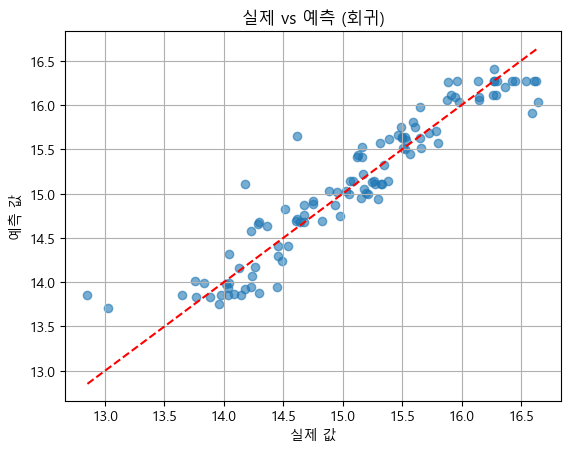

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows의 경우 기본 폰트: Malgun Gothic)
mpl.rc('font', family='Malgun Gothic')  # or 'AppleGothic' on macOS

# 음수 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 시각화 코드
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.title("실제 vs 예측 (회귀)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()


## 모델이 잘 분류한 샘플 시각화

In [21]:
# 예측 결과와 실제값 비교 (데이터프레임 생성)
results_df = X_test.copy()
results_df['실제값'] = y_test.values
results_df['예측값'] = y_pred
results_df['오차'] = np.abs(results_df['실제값'] - results_df['예측값'])

# 오차가 적은 상위 2개 (잘 맞춘 샘플)
print("✅ 모델이 잘 예측한 샘플 (오차가 거의 없음):")
print(results_df.sort_values(by='오차').head(2))

✅ 모델이 잘 예측한 샘플 (오차가 거의 없음):
          PM10       PM25   풍속(m/s)    풍향(16방위)      습도(%)   증기압(hPa)  \
300  53.725653  30.671642  1.983333  152.500000  52.083333   9.758333   
264  41.198923  23.552595  2.141667  147.083333  60.041667  14.170833   

     이슬점온도(°C)    현지기압(hPa)  해면기압(hPa)  최저운고(100m )  ...    월_6    월_7    월_8  \
300   6.570833  1010.000000  1020.1375    17.788291  ...  False  False  False   
264  12.066667  1002.854167  1012.8000    14.400000  ...  False  False  False   

       월_9   월_10   월_11   월_12        실제값        예측값        오차  
300  False   True  False  False  15.024281  15.023182  0.001099  
264   True  False  False  False  14.672596  14.676623  0.004027  

[2 rows x 41 columns]


## 모델이 잘못 분류한 샘플 시각화 및 원인 분석

❌ 모델이 잘못 예측한 샘플 (오차 큼):
          PM10       PM25   풍속(m/s)    풍향(16방위)      습도(%)   증기압(hPa)  \
21   80.977552  27.682048  3.587500  282.916667  52.833333   1.850000   
567  33.106483  20.486412  1.395833  192.083333  50.916667  22.641667   
357  78.640156  60.934638  1.825000  190.000000  82.791667   6.575000   
80   58.107132  30.780976  2.525000  280.000000  33.458333   3.258333   
203  53.726155  36.183238  2.129167  212.916667  89.041667  31.741667   

     이슬점온도(°C)    현지기압(hPa)    해면기압(hPa)  최저운고(100m )  ...    월_6    월_7  \
21  -15.683333  1016.145833  1027.379167     8.333333  ...  False  False   
567  19.458333   998.591667  1008.104167    61.500000  ...  False   True   
357   0.708333  1003.529167  1014.170833     5.550000  ...  False  False   
80   -8.375000  1010.129167  1020.670833    58.666667  ...  False  False   
203  25.008333   995.091667  1004.716667     6.208333  ...  False   True   

       월_8    월_9   월_10   월_11   월_12        실제값        예측값        오차  
21   Fa

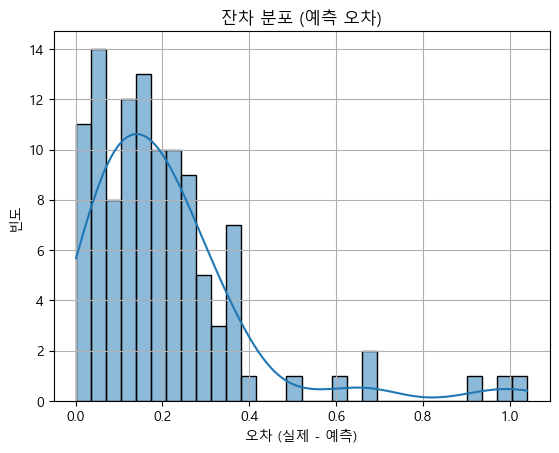


📊 오차와 상관관계가 높은 변수:
요일_6      0.509644
월_7       0.193348
월_12      0.156220
월_3       0.137023
판매량_어제    0.101598
Name: 오차, dtype: float64


In [22]:
# 오차가 큰 상위 5개 (예측 실패 샘플)
print("❌ 모델이 잘못 예측한 샘플 (오차 큼):")
print(results_df.sort_values(by='오차', ascending=False).head(5))

# 오차 분포 시각화 (잔차 히스토그램)
import seaborn as sns
sns.histplot(results_df['오차'], bins=30, kde=True)
plt.title("잔차 분포 (예측 오차)")
plt.xlabel("오차 (실제 - 예측)")
plt.ylabel("빈도")
plt.grid(True)
plt.show()

# 어떤 변수들이 오차에 영향을 많이 주는지 확인 (예시: 상관 분석)
correlation = results_df.corr(numeric_only=True)['오차'].sort_values(ascending=False)
print("\n📊 오차와 상관관계가 높은 변수:")
print(correlation.drop(['실제값', '예측값', '오차']).head(5))

In [23]:
grid

GridSearchCV(cv=3,
             estimator=StackingRegressor(cv=5,
                                         estimators=[('rf',
                                                      RandomForestRegressor(random_state=42)),
                                                     ('xgb',
                                                      XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   feature_we...
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=300,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))],
                                         final_estimator=HistGradientBoostingRegressor(),
                                         n_jobs=-1),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__n_estimators': [200, 300, 500],
                         'xgb__learning_rate': [0.03, 0.05, 0.07],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [200, 300]},
             scoring='r2')